# Competition 1. Predicting News Popularity

## Code

### Dependencies & Load Data

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [2]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [3]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
print(X.shape, y.shape)

(27643,) (27643,)


### Feature Engineering

##### Organize Positive / Negative Words

In [5]:
import os

POSITIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'positive-words.txt')
NEGATIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'negative-words.txt')
pos_words = []
neg_words = []


for line in open(POSITIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    pos_words.append(word)

for line in open(NEGATIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    neg_words.append(word)

In [6]:
print(len(pos_words))
print(len(neg_words))

2006
4783


#### Positive / Negative Word Stemmer

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_neg(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in neg_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_pos(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in pos_words and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/winston/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Stop Words Stemming

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    stemmer = EnglishStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

#### Testing Area

In [9]:
from bs4 import BeautifulSoup
import re
from string import punctuation
from collections import Counter

def feature_selection(data):
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    print("Title: ", soup.find("h1", {"class": "title"}).text)

    # Channel
    print("Data Channel: ", soup.find("article").get("data-channel"))

    # Author
    author_re = r'(?:By\s)?([a-zA-Z]+(\s[a-zA-Z]+)*)'
    if soup.head.find("span") == None:
        print("Author: None")
    else:
        print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

    # Related Topics
    print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

    # Time
    print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

    # Weekend
    print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    print("Total words: ", len(list(total.elements())))


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    print("Media count: ", media_count)

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    print("Link count: ", appealing_count)

    # POS & NEG count
    paragraph = section.find_all("p")
    pos_count = 0
    pos_words = []
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            pos_words.append(word)
    print("Positive count: ", pos_count)
    print("Positive words: ", pos_words)

    neg_count = 0
    neg_words = []
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            neg_words.append(word)
    print("Negative count: ", neg_count)
    print("Negative words: ", neg_words)

    # Question & Exclamation count
    q_count = 0
    ex_count = 0
    for tag in paragraph:
        if tag.text.find("?") != -1:
            q_count += tag.text.find("?")
        if tag.text.find("!") != -1:
            ex_count += tag.text.find("!")
    
    print("Question count: ", q_count)
    print("Exclamation count: ", ex_count)


feature_selection(X[0])

Title:  NASA's Grand Challenge: Stop Asteroids From Destroying Earth
Data Channel:  world
Author:  Clara Moskowitz
Topics:  ['Asteroid', ' Asteroids', ' challenge', ' Earth', ' Space', ' U.S.', ' World ']
Time:  15:04
Weekend:  0
Total words:  543
Media count:  0
Link count:  18
Positive count:  14
Positive words:  ['improv', 'pref', 'confid', 'win', 'support', 'benefit', 'valu', 'integr', 'win', 'support', 'import', 'accompl', 'innov', 'tim']
Negative count:  3
Negative words:  ['kil', 'dang', 'threats']
Question count:  0
Exclamation count:  0


#### All Vector Features (Word + Stats)

In [10]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

def feature_selection_all(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    # Time
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0"
    else:
        hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
        minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
        if hour * 60 + minute < 540:
            feature_str += "morning "
        elif hour * 60 + minute < 720:
            feature_str += "noon "
        elif hour * 60 + minute < 1020:
            feature_str += "afternoon "
        else:
            feature_str += "night "

    # Weekend
    if soup.time.text == None or soup.time.text == "":
        feature_str += "weekday "
    else:
        feature_str += "weekend " if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else "weekday "

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    if len(list(total.elements())) < 300:
        feature_str += 'wordshort '
    elif len(list(total.elements())) < 600:
        feature_str += 'wordmedium '
    else:
        feature_str += 'wordlong '


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    if media_count < 3:
        feature_str += "nomedia "
    elif media_count < 7:
        feature_str += "fewmedia "
    else:
        feature_str += "manymedia "

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    if appealing_count < 3:
        feature_str += "noappeal "
    elif appealing_count < 10:
        feature_str += "fewappeal "
    else:
        feature_str += "manyappeal "

    paragraph = section.find_all("p")
    # Statistics count
    stat_count = 0
    for tag in paragraph:
        number = r'\d+'
        matches = re.findall(number, tag.text)
        stat_count += len(matches)
    if stat_count < 5:
        feature_str += "fewstats "
    elif stat_count < 10:
        feature_str += "somestats "
    elif stat_count < 20:
        feature_str += "manystats "
    else:
        feature_str += "lotstats "

    # POS & NEG words
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "


    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "
    

    feature_str = re.sub(r'[,-.:\']+', '', feature_str.lower())
    return feature_str

print(feature_selection_all(X[0]))

nasas grand challenge stop asteroids from destroying earth world moskowitz asteroid asteroids challenge earth space us world afternoon weekday wordmedium nomedia manyappeal somestats improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats 


#### Feature Selection Part 1 (Only Word)

In [13]:
def feature_selection_part1(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    section = soup.find("section", {"class": "article-content"})
    paragraph = section.find_all("p")
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "

    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    feature_str = re.sub(r'[.:\']', '', feature_str.lower())
    return feature_str

print(feature_selection_part1(X[0]))

nasas grand challenge stop asteroids from destroying earth world moskowitz improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats asteroid asteroids challenge earth space us world 


#### Feature Selection Part 2 (Basic stats)

In [14]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

def feature_selection_part2(data):
    X = []
    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            feature_list.append(hour * 60 + minute)

        # Weekend
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            feature_list.append(1 if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else 0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        feature_list.append(len(list(total.elements())))

        # Script count
        script = soup.find_all("script")
        feature_list.append(len(script))

        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        h1_h2_count = len(section.find_all("h1")) + len(section.find_all("h2"))
        table_count = len(section.find_all("table")) + len(section.find_all("tr")) + len(section.find_all("td"))
        appealing_count = link_count + strong_count + h1_h2_count + table_count
        feature_list.append(appealing_count)

        paragraph = section.find_all("p")
        # Statistics count
        stat_count = 0
        for tag in paragraph:
            number = r'\d+'
            matches = re.findall(number, tag.text)
            stat_count += len(matches)
        feature_list.append(stat_count)

        # POS & NEG count
        pos_count = 0
        for tag in paragraph:
            pos_count += len(tokenizer_stem_pos(tag.text))
        feature_list.append(pos_count)

        neg_count = 0
        for tag in paragraph:
            neg_count += len(tokenizer_stem_neg(tag.text))
        feature_list.append(neg_count)

        # Question & Exclamation count
        q_count = 0
        for tag in paragraph:
            if tag.text.find("?") != -1:
                q_count += tag.text.find("?")
        feature_list.append(q_count)

        ex_count = 0
        for tag in paragraph:
            if tag.text.find("!") != -1:
                ex_count += tag.text.find("!")
        feature_list.append(ex_count)

        # word count of title
        feature_list.append(len(soup.find("h1", {"class": "title"}).text))
        
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
            

        X.append(feature_list)
    
    return np.array(X)

print(feature_selection_part2(X[:2]))

[[6.00000000e+00 9.04000000e+02 0.00000000e+00 5.43000000e+02
  0.00000000e+00 0.00000000e+00 1.80000000e+01 7.00000000e+00
  1.40000000e+01 3.00000000e+00 0.00000000e+00 0.00000000e+00
  6.00000000e+01 4.89731438e-01 4.81042654e+00]
 [3.00000000e+00 1.06000000e+03 0.00000000e+00 3.21000000e+02
  0.00000000e+00 0.00000000e+00 9.00000000e+00 2.00000000e+00
  5.00000000e+00 3.00000000e+00 0.00000000e+00 0.00000000e+00
  7.40000000e+01 4.74719101e-01 4.65449438e+00]]


#### Feature Selection Part 3 (Johnson's Version => Advance Stats)

In [19]:
import math

author_score =dict()
author_num = dict()
channel_score = dict()
channel_num = dict()
topic_score = dict()
topic_num = dict()
avg_author = 0
avg_channel = 0
avg_topic = 0

def feature_selection_part3(data, istraining):
    X = []
    idx=0
    global author_score
    global author_num 
    global channel_score 
    global channel_num 
    global topic_score 
    global topic_num 
    global avg_author 
    global avg_channel 
    global avg_topic 
    
    if(istraining):
        for html in data:
            soup = BeautifulSoup(html, 'html.parser')
            channel = soup.find("article").get("data-channel")
            if channel in channel_score:
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] += 1
            else : 
                channel_score[channel] = 0
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] = 1
            
            topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
            for topic in topics:
                if topic in topic_score:
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] += 1
                else : 
                    topic_score[topic] = 0
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] = 1


            # Author
            author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
            if soup.head.find("span") == None:
                continue
            else:
                author = re.search(author_re, soup.head.find("span").text).group(1)
                if author in author_score:
                    author_score[author] += 1 if int(y[idx])==1 else  0
                    author_num[author] += 1
                else : 
                    author_score[author] = 0
                    author_num[author] = 1
                    author_score[author] += 1 if int(y[idx])==1 else  0
            idx+=1
        total_channel = 0
        total_topic = 0
        total_author = 0
        for c,s in channel_score.items():
            avg_channel+=s
            total_channel+=channel_num[c]
        avg_channel = avg_channel/total_channel

        for c,s in topic_score.items():
            avg_topic+=s
            total_topic+=topic_num[c]
        avg_topic = avg_topic/total_topic

        for c,s in author_score.items():
            avg_author+=s
            total_author+=author_num[c]
        avg_author = avg_author/total_author

    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        # Author score
        author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        if soup.head.find("span") == None:
            feature_list.append(0.5)
        else:
            author = re.search(author_re, soup.head.find("span").text).group(1)
            if author in author_score:
                feature_list.append(author_score[author]/author_num[author])
            else:
                feature_list.append(0.5)
        # Channel score
        channel = soup.find("article").get("data-channel")
        if channel in channel_score:
            feature_list.append(channel_score[channel]/channel_num[channel])
        else:
            feature_list.append(0.5)
            
        # Topic score
        topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        total_score = 0
        order = 0 
        order_denominator = 0
        for i in range(len(topics)):
            order_denominator += math.exp(-0.5*i)

        for topic in topics:
            order_coef = math.exp(-0.5*order)/order_denominator
            if topic in topic_score:
                total_score+=(topic_score[topic]/topic_num[topic])*order_coef
            else:
                total_score+=0.5*order_coef
            order+=1
        
        feature_list.append(total_score) 

        # word count of title
        title = soup.find("h1", {"class": "title"}).text
        feature_list.append(len(title))
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
        
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            time = (hour * 60 + minute-300)%1440
            time_demarcation = 0
            if(300<=time and time<=720):
                time_demarcation = 1
            elif(720<time and time<=960):
                time_demarcation = 2
            elif(960<time and time <=1440):
                time_demarcation = 3
            else:
                time_demarcation = 4
            feature_list.append(time_demarcation)

        # Weekday
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            weekday = soup.time.get("datetime")[:3]
            if(weekday == "Mon"):
                feature_list.append(1)
            elif(weekday == "Tue"):
                feature_list.append(2)
            elif(weekday == "Wed"):
                feature_list.append(3)
            elif(weekday == "Thu"):
                feature_list.append(4)
            elif(weekday == "Fri"):
                feature_list.append(5)
            elif(weekday=="Sat"):
                feature_list.append(6)
            elif(weekday=="Sun"):
                feature_list.append(7)
            else: feature_list.append(0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        word_count = len(list(total.elements()))

        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count / word_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count / word_count)

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        neg_count = 0
        q_count = 0
        ex_count = 0
        para_count = 0
        content=""
        for tag in paragraph:
            content+=tag.text
            para_count += 1
            pos_count += len(tokenizer_stem_pos(tag.text))
            neg_count += len(tokenizer_stem_neg(tag.text))
            if tag.text.find("?") != -1:
                q_count += tag.text.find("?")
            if tag.text.find("!") != -1:
                ex_count += tag.text.find("!")
        word_cnt = len(list(total.elements()))
        feature_list.append(pos_count/word_cnt)    
        feature_list.append(neg_count/word_cnt)
        feature_list.append(q_count/word_cnt)
        feature_list.append(ex_count/word_cnt)
        feature_list.append(word_cnt/para_count)
        analyzer = SentimentIntensityAnalyzer()
        # Title sentiment analysis
        sentiment_title = analyzer.polarity_scores(title)
        feature_list.append(sentiment_title['compound'])
        # Content sentiment analysis
        sentiment_content = analyzer.polarity_scores(content)
        feature_list.append(sentiment_content['compound'])
        X.append(feature_list)
    return np.array(X)

print(feature_selection_part3(X[:2], True))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.00000000e+01
   4.89731438e-01  4.81042654e+00  6.00000000e+00  1.00000000e+00
   3.00000000e+00  0.00000000e+00  3.31491713e-02  2.57826888e-02
   5.52486188e-03  0.00000000e+00  0.00000000e+00  1.08600000e+02
  -3.61200000e-01  9.66700000e-01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  7.40000000e+01
   4.74719101e-01  4.65449438e+00  3.00000000e+00  2.00000000e+00
   4.00000000e+00  0.00000000e+00  2.80373832e-02  1.55763240e-02
   9.34579439e-03  0.00000000e+00  0.00000000e+00  4.01250000e+01
   3.57000000e-01  9.89300000e-01]]


### TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_all,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(X)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

# doc_tfidf = tfidf.transform(X).toarray()
# tfidf_sum = np.sum(doc_tfidf, axis=0)
# print("\n[vocabularies with highest tf-idf scores]")
# for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
#                         np.sort(tfidf_sum)[::-1][:top]):
#     print('{}: {}'.format(tok, v))

c:\Users\EmilyXia\anaconda3\envs\dl\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[vocabularies with smallest idf scores]
nomed: 1.58
weekday: 1.69
appeallong: 1.83
nightweekday: 2.00
wordlong: 2.00
appealmed: 2.04
wordshort: 2.11
manymed: 2.14
wordmed: 2.19
afternoon: 2.23


### Hashing Vectorizer

In [17]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

# hash words to 1024 buckets
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection,
                            tokenizer=tokenizer_stem_nostop)

# no .fit needed for HashingVectorizer, since it's defined by the hash function

# transform sentences to vectors of dimension 1024
# X_hash = hashvec.transform(X)
# print(X_hash.shape)

### Model Training

#### Iterate Version

In [22]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk

print(next(get_stream(path='./datasets/train.csv', size=5)))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


##### Approach 1. XGBClassifier

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

model = xgb.XGBClassifier()
batch_size = 512
stream = get_stream(path='./datasets/train.csv', size=batch_size)
train_auc, val_auc = [], []
iters = int((27643+batch_size-1)/(batch_size*2))
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity']
    if X_train is None:
        break
    X_train = tfidf.transform(X_train)
    y_train = LabelEncoder().fit_transform(y_train)
    if i == 0:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train, xgb_model='tmp.json')
    train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    train_auc.append(train_score)
    model.save_model('tmp.json')

    batch = next(stream)
    X_valid, y_valid = batch['Page content'], batch['Popularity']
    y_valid = LabelEncoder().fit_transform(y_valid)
    valid_score = roc_auc_score(y_valid, model.predict_proba(tfidf.transform(X_valid))[:,1])
    val_auc.append(valid_score)
    print(f'[{(i+1)*batch_size}/{X_train.shape[0]}]')
    print(f'Train score: {train_score}')
    print(f'Valid score: {valid_score}')


#### Once Version

##### Approach 1. XGBClassifier (Part 1) + XGBClassifier (Part 2) + Propotion

In [49]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

print('Begin Word Training...')
word_model = xgb.XGBClassifier(max_depth=10)
x_train_word = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
word_model.fit(x_train_word, y_train)


print('Begin Stats Training...')
stats_model = xgb.XGBClassifier(max_depth=10)
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f'Propotion = {i}')
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    print(f'Stats train score: {train_score}')
    print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Stats Training...
Begin Evaluation...
Propotion = 0.1
Stats train score: 0.8337489746948469
Stats valid score: 0.5381647821363221
Propotion = 0.2
Stats train score: 0.8538771468400634
Stats valid score: 0.5424207121841751
Propotion = 0.3
Stats train score: 0.8716052293672272
Stats valid score: 0.546162726998858
Propotion = 0.4
Stats train score: 0.8852657226003768
Stats valid score: 0.5490572462571346
Propotion = 0.5
Stats train score: 0.8934468680814405
Stats valid score: 0.5502538298920947
Propotion = 0.6
Stats train score: 0.895002950718581
Stats valid score: 0.5494158876364323
Propotion = 0.7
Stats train score: 0.8887981647937868
Stats valid score: 0.5471412859894432
Propotion = 0.8
Stats train score: 0.873531289236538
Stats valid score: 0.5440122528279733
Propotion = 0.9
Stats train score: 0.8483147518254196
Stats valid score: 0.5401605713554354


##### Appoach 2. XGBClassifier (Part 1) + GradientBoostingClassifier (Part 2) + Propotion

In [83]:
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

print('Begin Word Training...')
word_model = xgb.XGBClassifier()
x_train_word = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
word_model.fit(x_train_word, y_train)


print('Begin Stats Training...')
stats_model = HistGradientBoostingClassifier()
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
best_coef = 0
best_train = 0
best_valid = 0
coef_ = np.linspace(0,.5,101)
for i in coef_:
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    if valid_score > best_valid:
        best_valid = valid_score
        best_train = train_score
        best_coef = i

print(f'Best coef: {best_coef}')
print(f'Train score: {best_train}')
print(f'Valide score: {best_valid}')

Begin Word Training...
Begin Stats Training...
Begin Evaluation...
Best coef: 0.295
Train score: 0.8103657120014685
Valide score: 0.5659891770926032


##### Approach 3. RandomForestClassifier (Part 1) + GradientBoostingClassifier (Part 2) + Propotion

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

print('Begin Word Training...')
word_model = RandomForestClassifier()
x_train_word = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
word_model.fit(x_train_word, y_train)

print('Begin Saving...')
import pickle
filename = "backup_word.pickle"
# save model
pickle.dump(word_model, open(filename, "wb"))

print('Begin Stats Training...')
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Saving...')
import pickle
filename = "backup_stats.pickle"
# save model
pickle.dump(stats_model, open(filename, "wb"))

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
best_coef = 0
best_train = 0
best_valid = 0
coef_ = np.linspace(0,.5,21)
for i in coef_:
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    if valid_score > best_valid:
        best_valid = valid_score
        best_train = train_score
        best_coef = i

print(f'Best coef: {best_coef}') # 0.35
print(f'Train score: {best_train}')
print(f'Valide score: {best_valid}')

Begin Word Training...
Begin Saving...
Begin Stats Training...
Begin Saving...
Begin Evaluation...
Propotion = 0.0
Propotion = 0.025
Propotion = 0.05
Propotion = 0.07500000000000001
Propotion = 0.1
Propotion = 0.125
Propotion = 0.15000000000000002
Propotion = 0.17500000000000002
Propotion = 0.2
Propotion = 0.225
Propotion = 0.25
Propotion = 0.275
Propotion = 0.30000000000000004
Propotion = 0.325
Propotion = 0.35000000000000003
Propotion = 0.375
Propotion = 0.4
Propotion = 0.42500000000000004
Propotion = 0.45
Propotion = 0.47500000000000003
Propotion = 0.5
Train score: 0.9980189735758218
Valide score: 0.5762409434051226


##### Approach 4. GradientBoostingClassifier (Part 2)

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split




print('Begin Stats Training...')
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Saving...')
import pickle
filename = "backup_stats.pickle"
# save model
pickle.dump(stats_model, open(filename, "wb"))

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
best_coef = 0
best_train = 0
best_valid = 0
coef_ = np.linspace(0,.5,21)
for i in coef_:
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    if valid_score > best_valid:
        best_valid = valid_score
        best_train = train_score
        best_coef = i

print(f'Best coef: {best_coef}')
print(f'Train score: {best_train}')
print(f'Valide score: {best_valid}')

Begin Word Training...
Begin Saving...
Begin Stats Training...
Begin Saving...
Begin Evaluation...
Best coef: 0.325
Train score: 0.9942460362600725
Valide score: 0.5714620792381162


##### Approach 5. Voting Classifier (All)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)
word_model = RandomForestClassifier()
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
voting = VotingClassifier(estimators=[('rf', word_model), ('gbc', stats_model)], voting='soft')

print('Begin Word Training...')
x_train = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
y_valid = LabelEncoder().fit_transform(Y_valid)
voting = voting.fit(x_train, y_train)

print('Begin Saving...')
import pickle
filename = "backup_voting.pickle"
# save model
pickle.dump(voting, open(filename, "wb"))

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train)[:,1]
y_pred_valid = voting.predict_proba(tfidf.transform(X_valid))[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Saving...
Begin Evaluation...
Stats train score: 0.9996908653201391
Stats valid score: 0.5492559122616445


### Final Approach VotingClassifier (Johnson's Part 3)

#### Prepare Data

In [105]:
from sklearn.preprocessing import LabelEncoder
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)
x_train = feature_selection_part3(X_train, True)
x_valid = feature_selection_part3(X_valid, False)
y_train = LabelEncoder().fit_transform(Y_train)
y_valid = LabelEncoder().fit_transform(Y_valid)

In [106]:
import pickle
file_name = 'x_train_last_dance.pickle'
pickle.dump(x_train, open(file_name, "wb"))
file_name = 'x_valid_last_dance.pickle'
pickle.dump(x_valid, open(file_name, "wb"))
file_name = 'y_train_last_dance.pickle'
pickle.dump(y_train, open(file_name, "wb"))
file_name = 'y_valid_last_dance.pickle'
pickle.dump(y_valid, open(file_name, "wb"))

In [25]:
x_train = pickle.load(open('x_train_last_dance.pickle', 'rb'))
x_valid = pickle.load(open('x_valid_last_dance.pickle', 'rb'))
y_train = pickle.load(open('y_train_last_dance.pickle', 'rb'))
y_valid = pickle.load(open('y_valid_last_dance.pickle', 'rb'))

#### Testing XGBClassifier

In [122]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

model_v3 = XGBClassifier(n_estimators=400, learning_rate=0.0025, max_depth=6)

print('Begin Word Training...')
model_v3 = model_v3.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = model_v3.predict_proba(x_train)[:,1]
y_pred_valid = model_v3.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Evaluation...
Stats train score: 0.6601329938005939
Stats valid score: 0.5910334167486859


#### Testing RandomForestClassifier

In [73]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=350, max_depth=8, max_features=0.5)

print('Begin Word Training...')
voting = model.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = model.predict_proba(x_train)[:,1]
y_pred_valid = model.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Evaluation...
Stats train score: 0.740397027506228
Stats valid score: 0.5842086655466674


#### Testing GradientBoostingClassifier

In [109]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)

print('Begin Word Training...')
voting = model.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = model.predict_proba(x_train)[:,1]
y_pred_valid = model.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Evaluation...
Stats train score: 0.5951716816776015
Stats valid score: 0.5936696385567399


#### Testing VotingClassifier

In [130]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

model_v1 = XGBClassifier(n_estimators=400, learning_rate=0.002, max_depth=6)
model_v3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)

voting = VotingClassifier(estimators=[('v1', model_v1), ('v3', model_v3)], voting='soft')

print('Begin Voting Training...')
voting = voting.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train)[:,1]
y_pred_valid = voting.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Voting Training...
Begin Evaluation...
Stats train score: 0.6264490999002064
Stats valid score: 0.5958093601449124


### Prediction

In [39]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [40]:
y_pred = model.predict_proba(feature_selection_part3(X_test, False))[:,1]

In [39]:
y_pred_word = word_model.predict_proba(tfidf.transform(X_test))[:,1]
y_pred_stats = stats_model.predict_proba(feature_selection_part2(X_test))[:,1]
propo = 0.35
y_pred = y_pred_word*propo + y_pred_stats*(1-propo)

In [41]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643    0.447837
1      27644    0.436719
2      27645    0.439140
3      27646    0.578224
4      27647    0.456616
...      ...         ...
11842  39485    0.641587
11843  39486    0.476370
11844  39487    0.491440
11845  39488    0.418514
11846  39489    0.431437

[11847 rows x 2 columns]


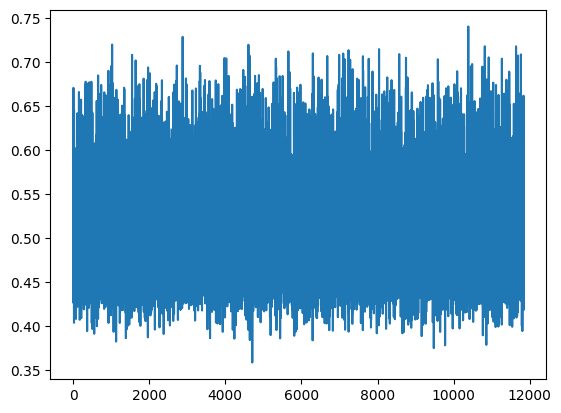

0.3585488978559971 0.7407863004889199


In [51]:
plt.plot(y_pred)
plt.show()
print(np.min(y_pred), np.max(y_pred))

In [ ]:
'''
          Id  Popularity
0      27643         0.4
1      27644         0.7
2      27645         0.4
3      27646         0.4
4      27647         0.5
...      ...         ...
11842  39485         0.5
11843  39486         0.5
11844  39487         0.5
11845  39488         0.6
11846  39489         0.5

[11847 rows x 2 columns]
'''

## Report

### Dependencie & Load Data
- Import necessary library and load csv.
### Read & Split Data
- Split data into X and y.
### Feature Engineering
- **Positive / Negative Word & Stemmer**
    - We create lists for both positive and negative words. In addition, we create positive and negative stemmer to analyze websites' sentiment.
- **Stop Word Stemmer**
    - We use LancasterStemmer to tokenize selected features.
- **All Vector Feature**
    - Features
        - Title
            - Title from header.
        - Data Channel
            - Data-Channel from html.
        - Author
            - Auther name from header and only get their family name. (e.g. Clara Moskowitz => Moskowitz).
        - Related Topics
            - Topics from footer.
        - Time
            - We convert `HH:MM` to `HH * 60 + MM`, then convert into `"morning"`, `"noon"`, `"afternoon"` and `"night"`.
        - Whether Weekend of Not
            -  `"weekday"` or `"weekend"`.
        - Word Count
            - Calculate total words and convert into `"wordshort"`, `"wordmedium"` and `"wordlong`.
        - Video + Image Count
            - Calculate the number of \<img>, \<picture>, \<figure>, \<video> and \<iframe>, then convert into `"nomedia"`, `"fewmedia"` and `"manymedia"`.
        - Link + Strong Header Count 
            - Calculate the number of \<a\> and \<strong\> and convert into `"nomedia"`, `"fewmedia"` and `"manymedia"`.
        - Number Count
            - Using regular expression to get the amount of numbers and convert into `"fewstats"`, `"somestats"`, `"manystats"` and `"lotstats"`.
        - Positive and Negative Words
            - Collect words from Positive / Negative words list in html.
- **Feature Part 1**
    - Features
        - Title from `feature_selection_all()`
        - Data Channel from `feature_selection_all()`
        - Author from `feature_selection_all()`
        - Related Topics from `feature_selection_all()`
- **Feature Part 2**
    - Features
        - Time from `feature_selection_all()` but is number
        - Weekend
            - `0` or `1`
        - Word count from `feature_selection_all()` but is number
        - Script count
            - Calculate the number of \<script>
        - Video + Image count from all but is number
        - Link + Strong count from all but is number
        - Number count from all but is number
        - Positive and Negative count
            - len(positive words) + len(negative words)
        - Number of `"?"` and `"!"`
        - Title length
        - Average word length and unique word rate
- **Feature Part 3**
    - Features from part2
    - Features from Johnson's part2
### TF-IDF
- We use `TfidfVectorizer` with preprocesser `feature_selection_all()`. However, we don't use IF-IDF in our final approach.
### Hashing Vectorizer
- We use `HashingVectorizer` with preprocess `feature_selection_all()`. However, we don't use Hashing Vectorizer in out final approach.
### Model Training
- Basically we test training two model, a `TF-IDF` one and a `feature_selection_part2()` or `feature_selection_part3()` one using different model including `RandomForestClassifier`, `XGBClassifier` and `GradientBoostingClassifier` etc. Then we combine their prediction with different propotion to get a better validation score.
### Final Approach
- In our final approach, we first discover that training only `feature_selection_part3()` with single model can hit better performance. After testing on many models, we choose VotingClassifier consists XGBClassifier and GradientBoostingClassifier as our final model.
### Prediction
- Prediction our final csv.
